In [ ]:
!zip -r './models.zip' './models/'

  adding: models/ (stored 0%)
  adding: models/model_weights_scratch.h5 (deflated 9%)
  adding: models/model_weights_res101_imagnet.h5 (deflated 16%)
  adding: models/model_weights_incpV3_imagnet.h5 (deflated 28%)
  adding: models/model_weights_res50_imagnet.h5 (deflated 16%)
  adding: models/model_weights_scratch_2.h5 (deflated 9%)
  adding: models/model_weights.h5 (deflated 12%)
  adding: models/model_weights_mobV2_imagnet.h5 (deflated 17%)


In [ ]:
from google.colab import files
files.download("./models.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nileshs21","key":"3ffbee5d519b3055bea896af2127a629"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                               title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
Cornell-University/arxiv                                          arXiv Dataset                                     877MB  2020-08-14 23:50:57           1780  
agirlcoding/all-space-missions-from-1957                          All Space Missions from 1957                      101KB  2020-08-13 16:18:58            808  
landlord/handwriting-recognition                                  Handwriting Recognition                             1GB  2020-08-05 17:20:36            268  
jmmvutu/summer-products-and-sales-in-ecommerce-wish               Sales of summer clothes in E-commerce Wish        351KB  2020-08-06 22:27:25            759  
andrewmvd/heart-failure-clinical-data   

In [ ]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 87% 105M/121M [00:00<00:00, 99.0MB/s] 
100% 121M/121M [00:01<00:00, 124MB/s] 


In [ ]:
!unzip face-expression-recognition-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating: images/validation/fear/9606.jpg  
  inflating:

In [ ]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow import keras
from keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array

In [ ]:
glob('./images/*')

['./images/train', './images/images', './images/validation']

In [ ]:
for x in glob('./images/train/*'):
    print(x.split('/')[-1], len(glob(x+'/*')))

surprise 3205
disgust 436
fear 4103
neutral 4982
happy 7164
sad 4938
angry 3993


In [ ]:
TRAIN_PATH = './images/train/'
VALID_PATH = './images/validation/'
MODEL_SAVE_PATH = './models/model_weights.h5'
BATCH_SIZE = 32
NUM_CLASSES = 7

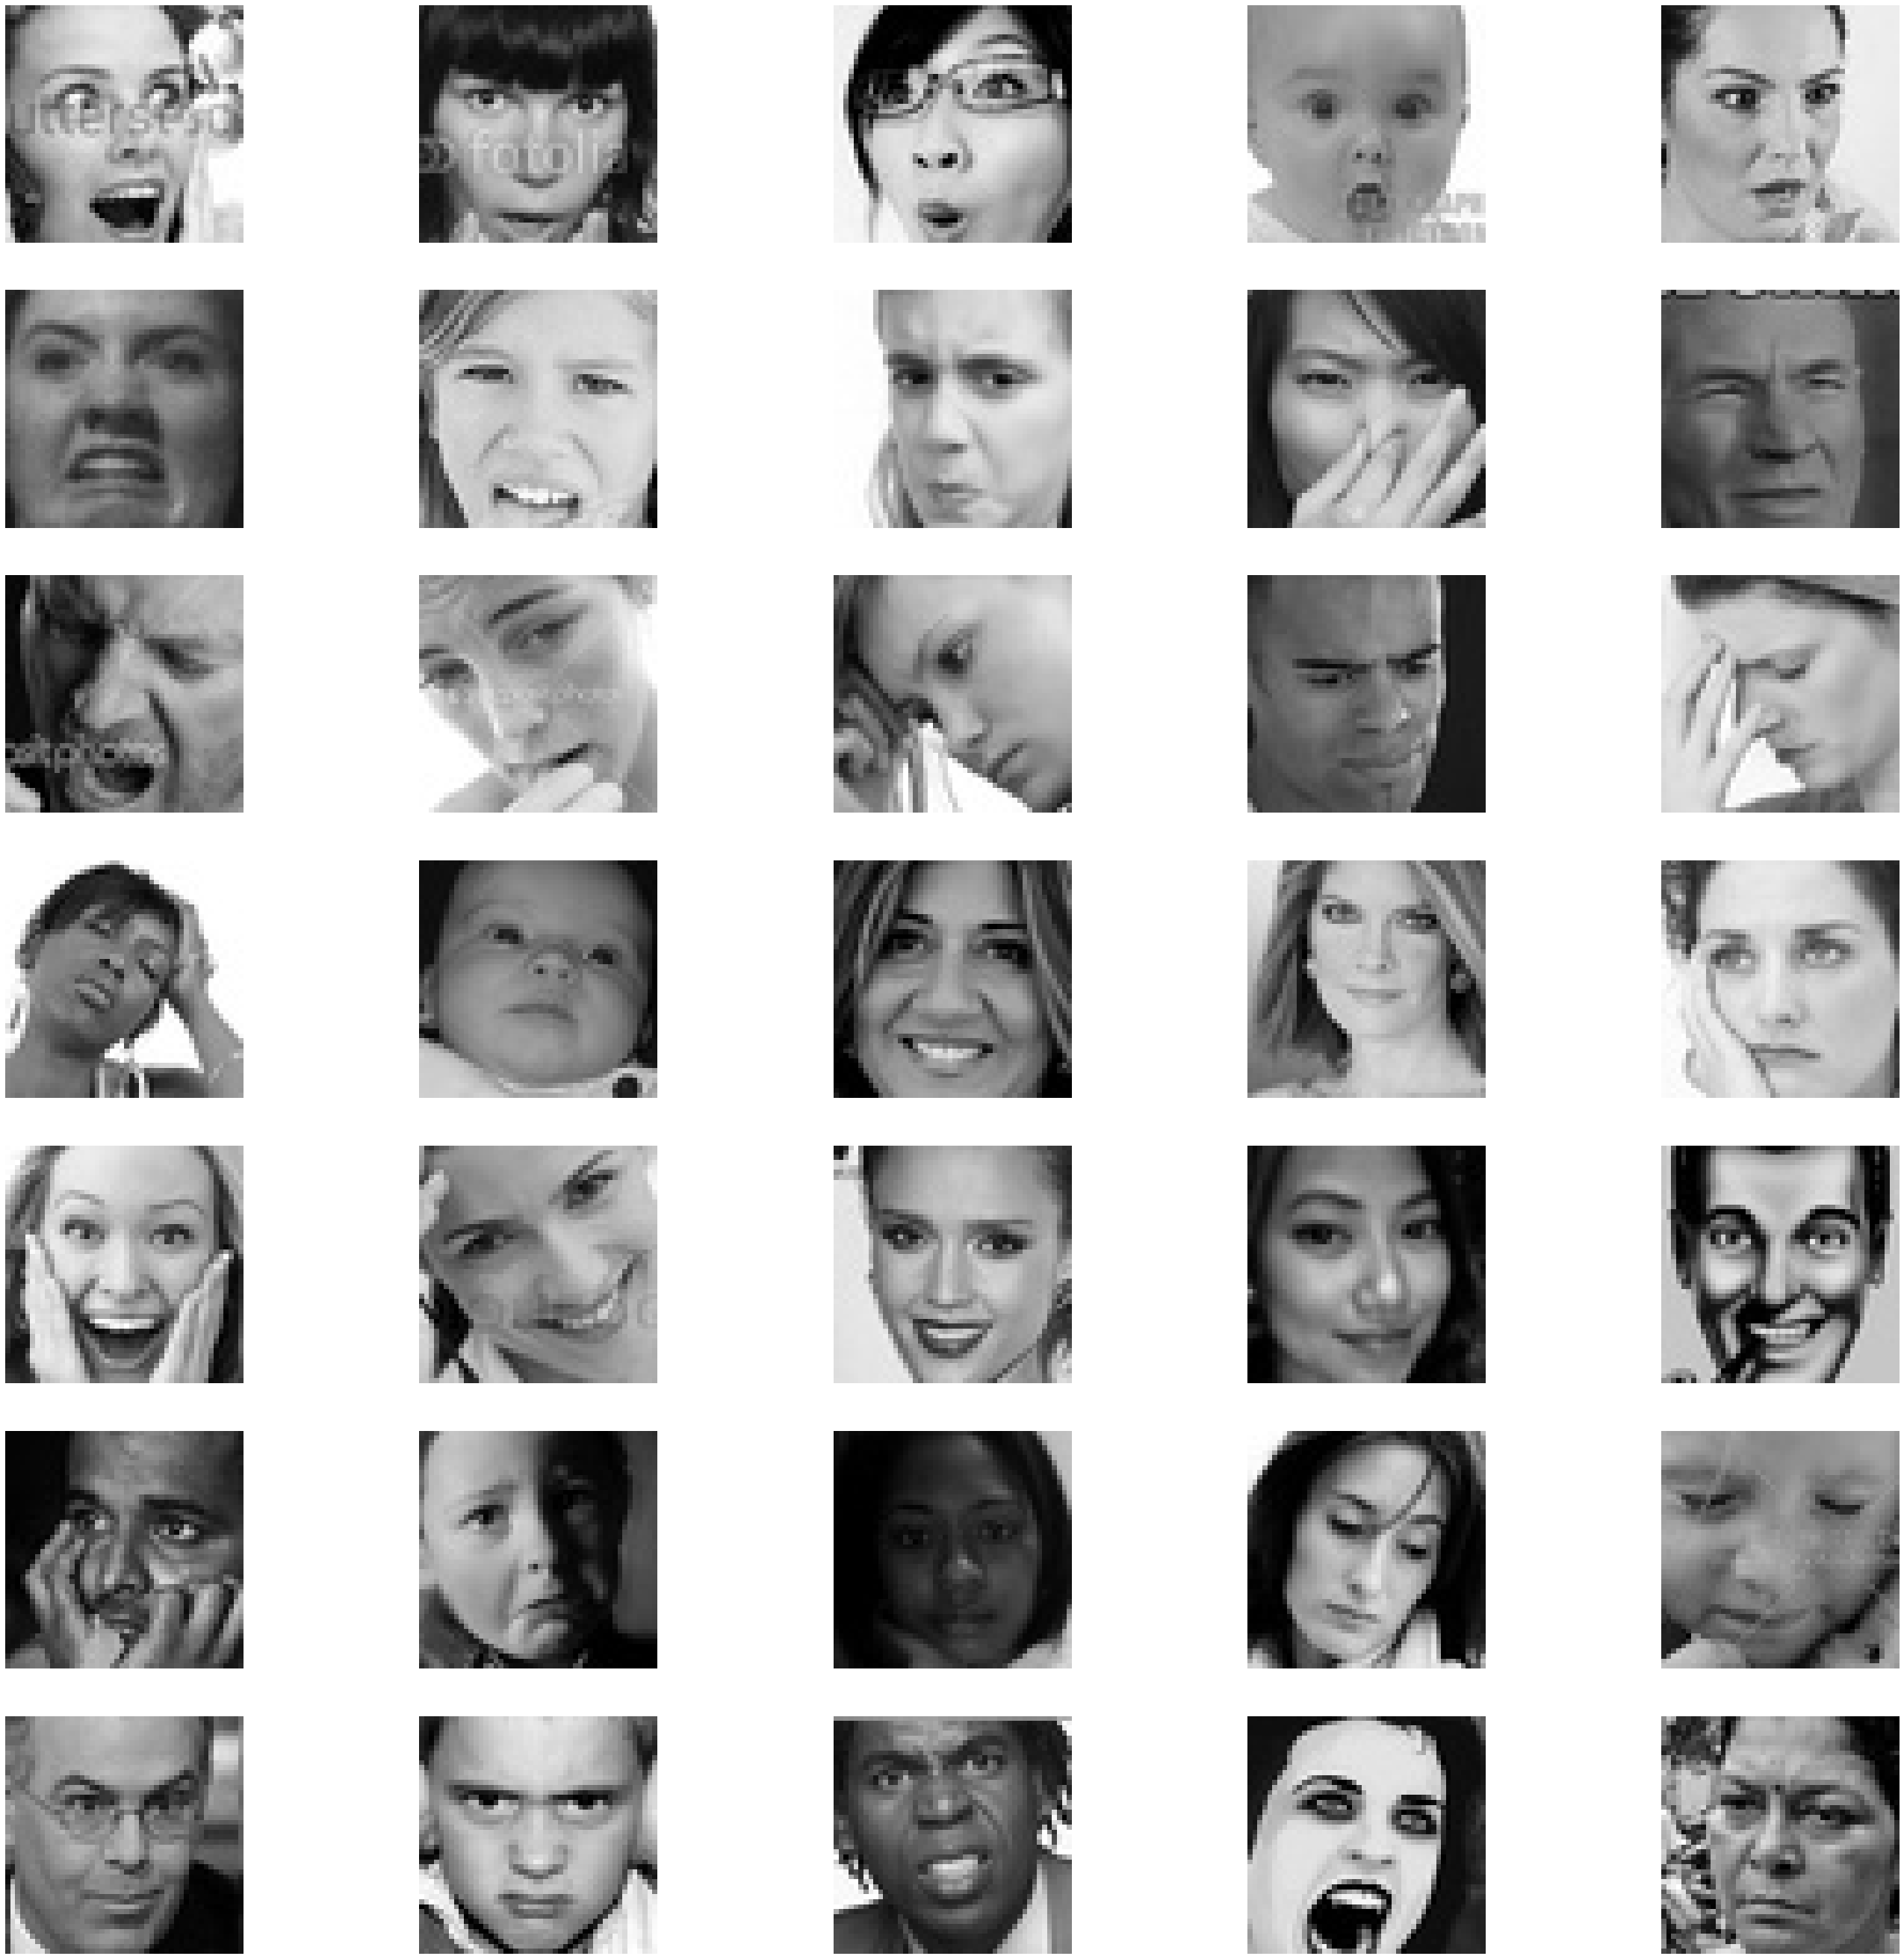

In [ ]:
plt.figure(0, figsize=(48,48))
cpt = 0

for expression in os.listdir(TRAIN_PATH):
    for i in range(1,6):
        cpt = cpt + 1
        sp=plt.subplot(7,5,cpt)
        sp.axis('Off')
        img_path = TRAIN_PATH + expression + "/" +os.listdir(TRAIN_PATH + expression)[i]
        img = load_img( img_path, target_size=(48,48))
        plt.imshow(img)


plt.show()

In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  shear_range=0.3,
                                  horizontal_flip=True)

datagen_valid = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(TRAIN_PATH,
                                                   target_size = (48,48),
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = True,
                                                   color_mode = 'rgb',
                                                   class_mode = 'categorical')

valid_generator = datagen_valid.flow_from_directory(VALID_PATH,
                                                   target_size = (48,48),
                                                   batch_size = BATCH_SIZE,
                                                   color_mode = 'rgb',
                                                   class_mode = 'categorical')

print(train_generator.classes)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
[0 0 0 ... 6 6 6]


In [ ]:
train_generator.class_indices, valid_generator.class_indices

({'angry': 0,
  'disgust': 1,
  'fear': 2,
  'happy': 3,
  'neutral': 4,
  'sad': 5,
  'surprise': 6},
 {'angry': 0,
  'disgust': 1,
  'fear': 2,
  'happy': 3,
  'neutral': 4,
  'sad': 5,
  'surprise': 6})

In [ ]:
from keras.applications.resnet50 import ResNet50

from keras.layers import Flatten, Dense, Dropout, BatchNormalization, MaxPool2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
model_res = ResNet50(include_top=False, weights='imagenet', input_shape=(48,48,3))

x = Flatten()(model_res.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# x = Dense(256, activation='relu')(x)

predictions = Dense(NUM_CLASSES, activation = 'softmax')(x)

final_model = Model(inputs= model_res.input, outputs = predictions)

final_model.compile(optimizer= Adam() , loss='categorical_crossentropy', metrics=['accuracy'])

final_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
______________________

In [ ]:
import tensorflow as tf
tf.test.is_gpu_available()

True

In [ ]:
MODEL_SAVE_PATH = './models/model_weights_res50_imagnet.h5'

checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# es = EarlyStopping(monitor='val_loss')

history = final_model.fit(train_generator,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps=valid_generator.n//valid_generator.batch_size,
                        epochs=150,
                        verbose=1,
                        validation_data = valid_generator,
                        callbacks=[checkpoint])

Epoch 1/150
900/900 [==============================] - ETA: 0s - loss: 1.7190 - accuracy: 0.3643
Epoch 00001: val_accuracy improved from -inf to 0.30682, saving model to ./models/model_weights_res50_imagnet.h5
900/900 [==============================] - 52s 57ms/step - loss: 1.7190 - accuracy: 0.3643 - val_loss: 8.2321 - val_accuracy: 0.3068
Epoch 2/150
900/900 [==============================] - ETA: 0s - loss: 1.7182 - accuracy: 0.3372
Epoch 00002: val_accuracy did not improve from 0.30682
900/900 [==============================] - 49s 54ms/step - loss: 1.7182 - accuracy: 0.3372 - val_loss: 1.8737 - val_accuracy: 0.1693
Epoch 3/150
900/900 [==============================] - ETA: 0s - loss: 1.7157 - accuracy: 0.3360
Epoch 00003: val_accuracy did not improve from 0.30682
900/900 [==============================] - 49s 54ms/step - loss: 1.7157 - accuracy: 0.3360 - val_loss: 5.0929 - val_accuracy: 0.1554
Epoch 4/150
899/900 [============================>.] - ETA: 0s - loss: 1.6141 - accurac

KeyboardInterrupt: ignored

In [ ]:
# without pretrained imagenet weights

model_res = ResNet50(include_top=False, weights=None, input_shape=(48,48,3))

x = Flatten()(model_res.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dense(256, activation='relu')(x)

predictions = Dense(NUM_CLASSES, activation = 'softmax')(x)

final_model = Model(inputs= model_res.input, outputs = predictions)

final_model.compile(optimizer= Adam() , loss='categorical_crossentropy', metrics=['accuracy'])

final_model.summary()

In [ ]:
MODEL_SAVE_PATH = './models/model_weights_res50.h5'

checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# es = EarlyStopping(monitor='val_loss')

history = final_model.fit(train_generator,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps=valid_generator.n//valid_generator.batch_size,
                        epochs=100,
                        verbose=1,
                        validation_data = valid_generator,
                        callbacks=[checkpoint])

In [ ]:
from keras import regularizers

In [ ]:
# model from scratch - self made

datagen_train = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  shear_range=0.3,
                                  horizontal_flip=True)

datagen_valid = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(TRAIN_PATH,
                                                   target_size = (48,48),
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = True,
                                                   color_mode = 'grayscale',
                                                   class_mode = 'categorical')

valid_generator = datagen_valid.flow_from_directory(VALID_PATH,
                                                   target_size = (48,48),
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = False,
                                                   color_mode = 'grayscale',
                                                   class_mode = 'categorical')

print(train_generator.classes)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
[0 0 0 ... 6 6 6]


In [ ]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

def conv_layer(model, num_filters, kernel_size, pad='same'):
    model.add(Conv2D(num_filters, kernel_size, padding=pad))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    return model 

def fc_layer(model, num_filters):
    model.add(Dense(num_filters, bias_regularizer=regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))  
    return model

model = Sequential()
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model = conv_layer(model, 128, (3,3))
model = conv_layer(model, 256, (5,5))
model = conv_layer(model, 256, (3,3))
# model = conv_layer(model, 512, (3,3))
# model = conv_layer(model, 512, (3,3))

model.add(Flatten())

model = fc_layer(model, 1024)
# model = fc_layer(model, 512)
model = fc_layer(model, 256)

model.add(Dense(NUM_CLASSES, activation= 'softmax'))

model.compile(optimizer= Adam() , loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [ ]:
MODEL_SAVE_PATH = './models/model_weights_scratch_2_1.h5'

# model = load_model('./models/model_weights_scratch_2.h5')

checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# es = EarlyStopping(monitor='val_loss')

history = model.fit(train_generator,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps=valid_generator.n//valid_generator.batch_size,
                        epochs=1,
                        verbose=1,
                        validation_data = valid_generator,
                        callbacks=[checkpoint])

model.save('./models/1.h5')

899/900 [============================>.] - ETA: 0s - loss: 1.4009 - accuracy: 0.4613
Epoch 00001: val_accuracy improved from -inf to 0.46974, saving model to ./models/model_weights_scratch_2_1.h5
900/900 [==============================] - 35s 39ms/step - loss: 1.4008 - accuracy: 0.4613 - val_loss: 1.4260 - val_accuracy: 0.4697


In [ ]:
import pickle

with open('/model_scratch_2.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# history = pickle.load(open('/trainHistoryDict'), "rb")

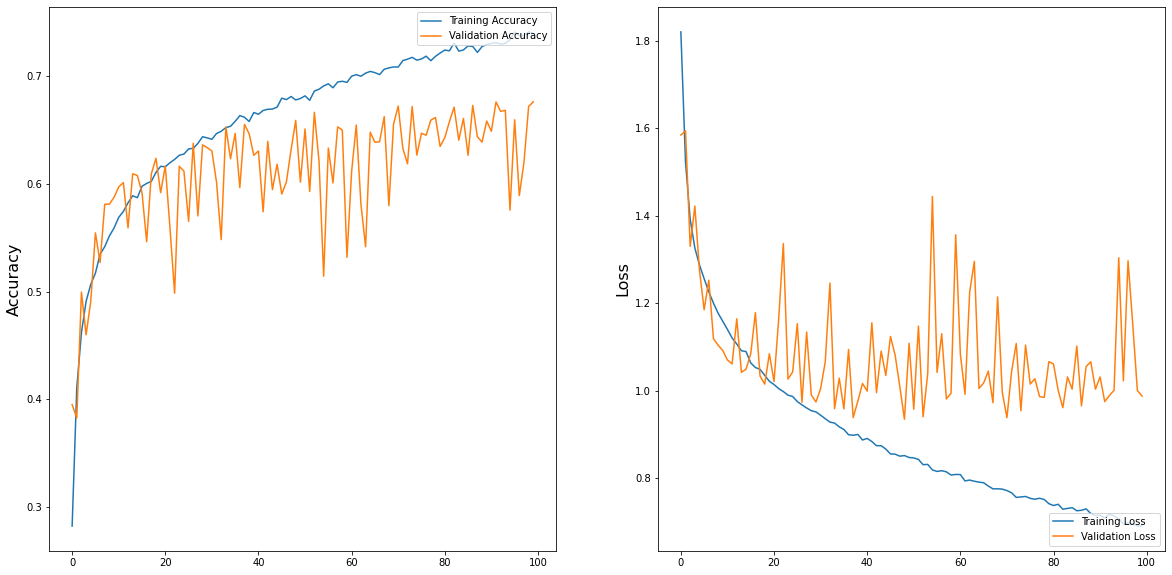

In [ ]:
# model_weights_scratch2

plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='lower right')

plt.show()

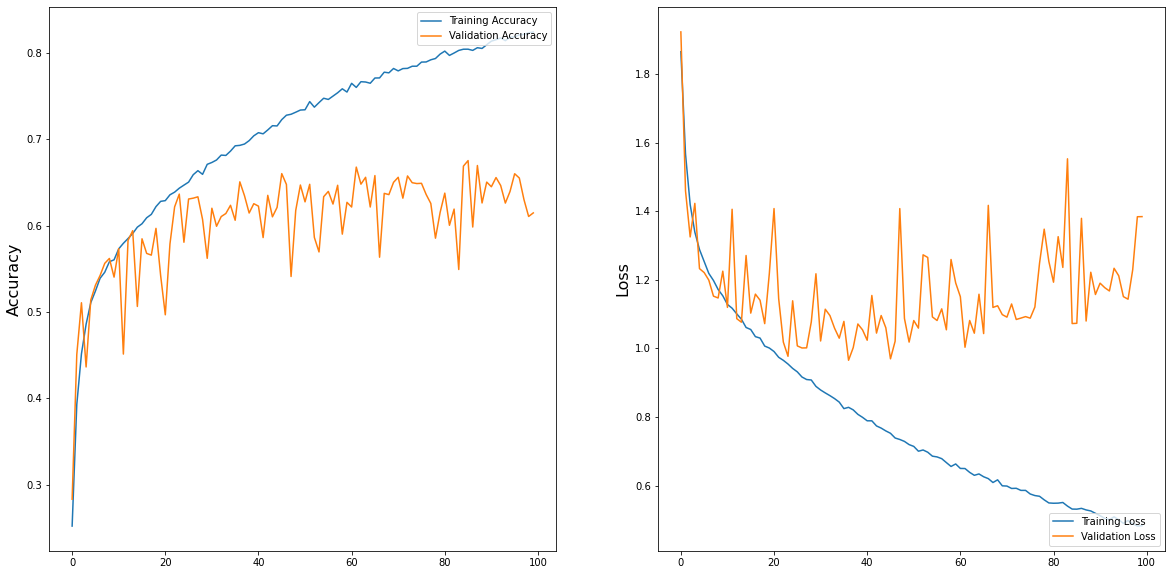

In [ ]:
# model_weights_scratch1

plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='lower right')

plt.show()

In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  shear_range=0.3,
                                  horizontal_flip=True)

datagen_valid = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(TRAIN_PATH,
                                                   target_size = (48,48),
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = True,
                                                   color_mode = 'rgb',
                                                   class_mode = 'categorical')

valid_generator = datagen_valid.flow_from_directory(VALID_PATH,
                                                   target_size = (48,48),
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = False,
                                                   color_mode = 'rgb',
                                                   class_mode = 'categorical')

print(train_generator.classes)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
[0 0 0 ... 6 6 6]


In [ ]:
# MobileNet-V2


from keras.applications import MobileNetV2

model_mobv2 = MobileNetV2(include_top=False, weights='imagenet', input_shape=(48,48,3))


x = Flatten()(model_mobv2.output)
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dense(256, activation='relu')(x)

predictions = Dense(NUM_CLASSES, activation = 'softmax')(x)

final_model = Model(inputs= model_mobv2.input, outputs = predictions)

final_model.compile(optimizer= Adam() , loss='categorical_crossentropy', metrics=['accuracy'])

final_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 49, 49, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 24, 24, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 24, 24, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
MODEL_SAVE_PATH = './models/model_weights_mobV2_imagnet.h5'

checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# es = EarlyStopping(monitor='val_loss')

history = final_model.fit(train_generator,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps=valid_generator.n//valid_generator.batch_size,
                        epochs=150,
                        verbose=1,
                        validation_data = valid_generator,
                        callbacks=[checkpoint])

Epoch 1/150
899/900 [============================>.] - ETA: 0s - loss: 1.6791 - accuracy: 0.3542
Epoch 00001: val_accuracy improved from -inf to 0.35256, saving model to ./models/model_weights_mobV2_imagnet.h5
900/900 [==============================] - 38s 42ms/step - loss: 1.6789 - accuracy: 0.3543 - val_loss: 1.8340 - val_accuracy: 0.3526
Epoch 2/150
899/900 [============================>.] - ETA: 0s - loss: 1.4332 - accuracy: 0.4548
Epoch 00002: val_accuracy improved from 0.35256 to 0.42216, saving model to ./models/model_weights_mobV2_imagnet.h5
900/900 [==============================] - 37s 41ms/step - loss: 1.4333 - accuracy: 0.4546 - val_loss: 2.1206 - val_accuracy: 0.4222
Epoch 3/150
899/900 [============================>.] - ETA: 0s - loss: 1.3608 - accuracy: 0.4857
Epoch 00003: val_accuracy improved from 0.42216 to 0.47173, saving model to ./models/model_weights_mobV2_imagnet.h5
900/900 [==============================] - 37s 41ms/step - loss: 1.3607 - accuracy: 0.4857 - val_l

In [ ]:
# inception v3
datagen_train = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  shear_range=0.3,
                                  horizontal_flip=True)

datagen_valid = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(TRAIN_PATH,
                                                   target_size = (75,75),
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = True,
                                                   color_mode = 'rgb',
                                                   class_mode = 'categorical')

valid_generator = datagen_valid.flow_from_directory(VALID_PATH,
                                                   target_size = (75,75),
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = False,
                                                   color_mode = 'rgb',
                                                   class_mode = 'categorical')

print(train_generator.classes)


from keras.applications import InceptionV3

model_incpv3 = InceptionV3(include_top=False, weights='imagenet', input_shape=(75,75,3))


x = Flatten()(model_incpv3.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# x = Dense(512, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.25)(x)
# x = Dense(256, activation='relu')(x)

predictions = Dense(NUM_CLASSES, activation = 'softmax')(x)

final_model = Model(inputs= model_incpv3.input, outputs = predictions)

final_model.compile(optimizer= Adam() , loss='categorical_crossentropy', metrics=['accuracy'])

final_model.summary()

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
[0 0 0 ... 6 6 6]
Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 37, 37, 32)   864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_106 (BatchN (None, 37, 37, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 37, 37, 32)   0           batch_normalizati

In [ ]:
from keras.models import load_model

In [ ]:
MODEL_SAVE_PATH = './models/model_weights_incpV3_imagnet.h5'

checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# es = EarlyStopping(monitor='val_loss')

history = final_model.fit(train_generator,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps=valid_generator.n//valid_generator.batch_size,
                        epochs=100,
                        verbose=1,
                        validation_data = valid_generator,
                        callbacks=[checkpoint])

Epoch 1/100
450/450 [==============================] - ETA: 0s - loss: 1.7141 - accuracy: 0.3559
Epoch 00001: val_accuracy improved from -inf to 0.29063, saving model to ./models/model_weights_incpV3_imagnet.h5
450/450 [==============================] - 58s 130ms/step - loss: 1.7141 - accuracy: 0.3559 - val_loss: 7.6212 - val_accuracy: 0.2906
Epoch 2/100
 52/450 [==>...........................] - ETA: 46s - loss: 1.5455 - accuracy: 0.4041

KeyboardInterrupt: ignored

In [ ]:
%tensorflow_version 2.2.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.2.0`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
import tensorflow as tf
tf.__version__

import keras
keras.__version__

'2.4.3'

In [ ]:
MODEL_SAVE_PATH = './models/model_weights_res50_imagnet.h5'

checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# es = EarlyStopping(monitor='val_loss')

history = final_model.fit(train_generator,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps=valid_generator.n//valid_generator.batch_size,
                        epochs=100,
                        verbose=1,
                        validation_data = valid_generator,
                        callbacks=[checkpoint])

Epoch 1/100
 11/450 [..............................] - ETA: 34s - loss: 1.3857 - accuracy: 0.4977

KeyboardInterrupt: ignored

In [ ]:
# ResNet101


from keras.applications import ResNet101

model_res_101 = ResNet101(include_top=False, weights='imagenet', input_shape=(48,48,3))


x = Flatten()(model_res_101.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
# x = Dense(256, activation='relu')(x)

predictions = Dense(NUM_CLASSES, activation = 'softmax')(x)

final_model = Model(inputs= model_res_101.input, outputs = predictions)

final_model.compile(optimizer= Adam() , loss='categorical_crossentropy', metrics=['accuracy'])

final_model.summary()

MODEL_SAVE_PATH = './models/model_weights_res101_imagnet.h5'

checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# es = EarlyStopping(monitor='val_loss')

history = final_model.fit(train_generator,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps=valid_generator.n//valid_generator.batch_size,
                        epochs=100,
                        verbose=1,
                        validation_data = valid_generator,
                        callbacks=[checkpoint])

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
MODEL_SAVE_PATH = './models/model_weights_res101_imagnet.h5'

checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# es = EarlyStopping(monitor='val_loss')

history = final_model.fit(train_generator,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps=valid_generator.n//valid_generator.batch_size,
                        epochs=100,
                        verbose=1,
                        validation_data = valid_generator,
                        callbacks=[checkpoint])

Epoch 1/100
450/450 [==============================] - ETA: 0s - loss: 1.8456 - accuracy: 0.2917
Epoch 00001: val_accuracy improved from -inf to 0.27599, saving model to ./models/model_weights_res101_imagnet.h5
450/450 [==============================] - 61s 135ms/step - loss: 1.8456 - accuracy: 0.2917 - val_loss: 1.8934 - val_accuracy: 0.2760
Epoch 2/100
450/450 [==============================] - ETA: 0s - loss: 1.5398 - accuracy: 0.3993
Epoch 00002: val_accuracy improved from 0.27599 to 0.37670, saving model to ./models/model_weights_res101_imagnet.h5
450/450 [==============================] - 58s 130ms/step - loss: 1.5398 - accuracy: 0.3993 - val_loss: 1.7789 - val_accuracy: 0.3767
Epoch 3/100
450/450 [==============================] - ETA: 0s - loss: 1.5743 - accuracy: 0.3831
Epoch 00003: val_accuracy did not improve from 0.37670
450/450 [==============================] - 56s 124ms/step - loss: 1.5743 - accuracy: 0.3831 - val_loss: 86.3842 - val_accuracy: 0.2572
Epoch 4/100
450/450 

KeyboardInterrupt: ignored

In [ ]:
1+2

3